In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from google.colab import files
files.upload() #upload kaggle.json

!mkdir -p .kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d asad1m9a9h6mood/news-articles
!rm ~/.kaggle/kaggle.json

!unzip news-articles.zip
!rm news-articles.zip

Saving kaggle.json to kaggle.json
  0% 0.00/1.73M [00:00<?, ?B/s]
100% 1.73M/1.73M [00:00<00:00, 122MB/s]
Archive:  news-articles.zip
  inflating: Articles.csv            


In [0]:
from IPython.display import display

import pandas as pd
import numpy as np

odf = pd.read_csv('Articles.csv', encoding='unicode_escape')
display(odf.sample(10))

odf['NewsType'].unique()


,Article,Date,Heading,NewsType
2597,ISLAMABAD: Advisor to Prime Minister on Foreig...,1/14/2017,Sartaj Aziz invites businessmen of Oman to inv...,business
78,London: World oil prices sank Friday after the...,3/13/2015,oil market drops on iea price warning,business
2576,strong>TEHRAN: President Hassan Rouhani sought...,1/2/2017,Rouhani pledges to reverse slide of Irans curr...,business
479,strong>SINGAPORE: Crude oil futures rebounded ...,2/17/2016,Oil rebounds on investor optimism over produce...,business
1920,strong>NEW YORK: Real Madrid star Cristiano Ro...,6/9/2016,Ronaldo Messi surpass Tiger Mayweather worlds ...,sports
301,Singapore: Oil prices fell in Asia Monday as i...,9/28/2015,oil prices ease in asi,business
409,strong>BERLIN: Global economic growth will be ...,12/30/2015,Global growth will be disappointing in 2016,business
1059,AUCKLAND: Colin Munro blasted New Zealand´s f...,1/10/2016,Record breakers Guptill Munro lead NZ,sports
2130,strong>LONDON: Andy Murray produced the kind o...,7/1/2016,Regal Murray hurries into round three of Wimbled,sports
2446,strong>STOCKHOLM: The World Bank´s new chief e...,10/10/2016,World Banks top economist tipped for Nob,business


array(['business', 'sports'], dtype=object)

In [0]:
# Clean the data
df = odf.drop(['Date', 'Heading'], axis=1)

cdf = df.Article \
.str.normalize('NFKD')\
.str.encode('ASCII', 'ignore')\
.str.decode('utf-8')\
.str.replace('(\'s)|( *strong>)|(</strong)|(["<>])', ' ')\
.str.replace('\'d', ' would')\
.str.replace('\s+', ' ')\
.str.extract('^(?P<City>[\w ]+): (?P<Article>.*)$') \
 
df = pd.concat([
                df.NewsType,
                # cdf.City.str.upper(),
                cdf.Article, 
              ], axis=1).dropna()

import re

# Check there are no strange characters left
print('Articles with strange characters: ',
    list(filter(lambda x: re.match('[\n!"#$%&\'()*+,./:;<=>?@[\]^{|}]', x), 
                list(df.Article))))


display(df.sample(10))

Articles with strange characters:  []


,NewsType,Article
2639,business,The Government has announced to raise prices o...
2253,sports,Pakistan captain Misbah-ul-Haq became the olde...
289,business,"Minister for Petroleum and Natural Resources, ..."
1362,sports,A team of Pakistani security experts on Sunday...
1767,sports,Alastair Cooks bid to become the first England...
173,business,Foreigners working in the energy-rich Arab sta...
2279,sports,India s test ranking has long been based on th...
2189,sports,"South Korean swimming star Park Tae-Hwan, who ..."
2577,business,China has begun its first freight train servic...
1174,sports,Pakistani swimmer Lianna Catherine Swan won a ...


In [0]:
np.random.seed(7052020)
fdf = df.reindex(np.random.permutation(df.index))

def split(data, percs):
  if sum(percs) != 100:
    throw("Bad percs: sum is not 100%")
  result = []
  current = 0
  for p in percs:
    next = current + int(data.size * p / 100)
    result.append(data[current:next])
  return tuple(result)

trainset, testset, validset = split(fdf, [70, 20, 10])

In [0]:
import fastai
from fastai.text.data import TextDataBunch

!mkdir -p data
data = TextDataBunch.from_df('data', trainset, testset, validset)
data.show_batch()

text,target
"xxbos xxmaj finance xxmaj minister xxmaj ishaq xxmaj dar presented the xxmaj federal xxmaj budget 2015 - 16 in the xxmaj national xxmaj assembly on xxmaj friday , eyeing an ambitious economic growth target of 5.5 percent . xxmaj prime xxmaj minister xxmaj nawaz xxmaj sharif arrived in the xxmaj national xxmaj assembly for the special budget session in which xxmaj finance xxmaj minister xxmaj ishaq xxmaj dar presented budgetary",business
"xxbos xxmaj as xxmaj senate xxmaj chairman xxmaj raza xxmaj xxunk ruled against government institutions which refused to disclose names of beneficiaries before the xxmaj parliament , xxmaj jang xxmaj group months long investigation revealed that more than 80 percent loans were written off by the state - owned banks and private financial institutions in last 25 years in tenure of former military ruler xxmaj pervez xxmaj musharraf , bursting",business
"xxbos xxmaj prime xxmaj minister xxmaj nawaz xxmaj sharif on xxmaj thursday said xxmaj pakistan was set on track of sustainable growth and was ready to do business with the world . xxmaj pakistan with its sixth largest population in the world , 80 million middle class , blessed with human and natural resources , xxunk located , politically stable , offering attractive policies is a destination no global player",business
"xxbos xxmaj fakhar xxmaj zaman slammed a spectacular century to help xxmaj khyber xxmaj pakhtunkhwa xxunk xxmaj punjab by 151 runs in the final of xxmaj pakistan xxmaj cup 2016 at xxmaj iqbal xxmaj stadium , xxmaj faisalabad , on xxmaj sunday . xxmaj in the day - night decider , xxmaj fakhar ( 115 ) and xxmaj ahmed xxmaj shehzad ( 62 ) gave a rapid start to enable",sports
xxbos xxmaj india unveiled a fire - fighting budget on xxmaj monday that seeks to win back support among rural voters for xxmaj prime xxmaj minister xxmaj narendra xxmaj modi s government and sustain growth against a grim global backdrop - all without borrowing more . xxmaj finance xxmaj minister xxmaj arun xxmaj jaitley s third budget marked a strategic shift by addressing rural distress in a country of 1.3,business


In [0]:
data.save('bunch')

In [0]:
from fastai.text import *

learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5)

In [0]:
learn.lr_find()
learn.save('init')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-05
Min loss divided by 10: 3.98E-03


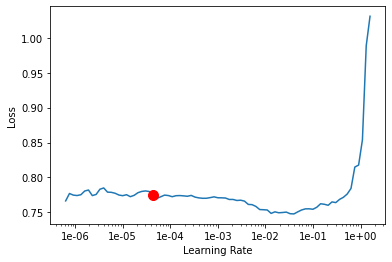

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1.45E-03
learn.load('init');
learn.fit_one_cycle(1, lr)
learn.save('first');

epoch,train_loss,valid_loss,accuracy,time
0,0.757454,0.690440,0.527508,00:29


Min numerical gradient: 1.43E-03
Min loss divided by 10: 1.82E-05


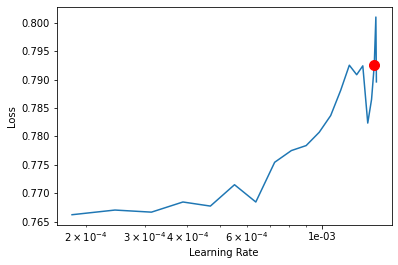

In [0]:
learn.load('first');
learn.recorder.plot(suggestion=True);

In [0]:
lr = 1.43E-03

learn.load('first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr))
learn.save('second');

epoch,train_loss,valid_loss,accuracy,time
0,0.702516,0.672148,0.696872,00:31


Min numerical gradient: 1.41E-03
Min loss divided by 10: 2.41E-05


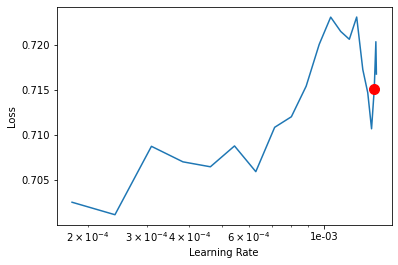

In [0]:
learn.load('second');
learn.recorder.plot(suggestion=True);

In [0]:
lr = 1.41e-3

learn.load('second');
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr))
learn.save('third');

epoch,train_loss,valid_loss,accuracy,time
0,0.571512,0.448469,0.812298,00:43


Min numerical gradient: 1.36E-03
Min loss divided by 10: 6.20E-05


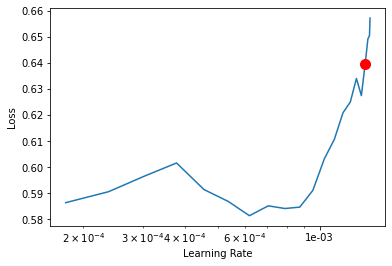

In [0]:
learn.load('third');
learn.recorder.plot(suggestion=True);

In [0]:
lr = 1.25e-3

learn.load('third');
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr))
learn.save('fune_tuned');

epoch,train_loss,valid_loss,accuracy,time
0,0.455593,1.322501,0.529666,00:57
1,0.359760,1.185480,0.536138,00:55
2,0.246743,0.321020,0.834951,01:00
3,0.183242,0.652709,0.640777,01:00
4,0.143092,0.128786,0.954693,00:52
5,0.122407,0.045857,0.988134,00:55
6,0.100782,0.035704,0.991370,01:00
7,0.089223,0.225555,0.907228,00:53
8,0.077670,0.025351,0.994606,00:55
9,0.067073,0.029855,0.992449,00:57


In [0]:
learn.load('fune_tuned');

import re

business_article = """
After a day of swinging between gains and losses, stocks on Wall Street ended with a small decline Wednesday.
"""

sports_article = """
LONDON — The sticking point in talks about reopening the Premier League, the richest league in global soccer, is not about how it would affect the best and wealthiest clubs, but about the way it would affect the worst ones.
"""

def predict(text):
  text = re.sub('\s+', ' ', text)
  (pred, predraw, tens) = learn.predict(text)
  return (pred.obj, predraw, tens)

display(predict(business_article))
display(predict(sports_article))


('business', tensor(0), tensor([0.9626, 0.0374]))

('sports', tensor(1), tensor([0.2820, 0.7180]))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

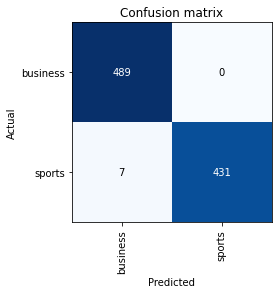

In [0]:
interp.plot_confusion_matrix()